In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def Get_FZ_Directions(X1,Y1,X2,Y2):
    long1 = np.radians(X1)
    long2 = np.radians(X2)
    lat1 = np.radians(Y1)
    lat2 = np.radians(Y2)

    bearing = np.arctan2(np.sin(long2-long1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1))
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360

    return bearing

In [3]:
#PathToPlateModel = '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Global_Model_WD_Internal_Release_2015_v1/'
rotation_filename = '/Users/Andrew/Documents/PhD/Models/Muller_etal_AREPS_Supplement/Global_EarthByte_230-0Ma_GK07_AREPS.rot'


Region = 'SouthAtlantic'

if Region is 'SouthAtlantic':
    SeedPoints = zip([-5,-15,-25,-35,-45],[-11.8,-12.8,-15.5,-16,-15.5])
    left_plate = 701
    right_plate = 201
    times = np.asarray([0,10.9,20.1,33.1,40.1,47.9,55.9,60.1,67.7,83,96,120.4,125,140])


time_intervals = np.diff(times)
AnchorPlate = 1

rotation_model=pygplates.RotationModel(rotation_filename)

# CREATE FLOWLINE
# POINTS ON THE FLOWLINE
points = []
for j in range(0,4):
    points.append(SeedPoints[j])
multi_point = pygplates.MultiPointOnSphere(points)

reverse_reconstruct=(rotation_model, 0, 1)

flowline_feature1 = pygplates.Feature(pygplates.FeatureType.create_gpml('Flowline'))
flowline_feature1.set_geometry(multi_point)
flowline_feature1.set_times(times)
flowline_feature1.set_valid_time(np.max(times), np.min(times))
flowline_feature1.set_left_plate(left_plate)
flowline_feature1.set_right_plate(right_plate)
flowline_feature1.set_geometry(multi_point, reverse_reconstruct=(rotation_model,0))

# reconstruct the flowline
reconstruction_time=0
reconstructed_flowlines1 = []
pygplates.reconstruct(flowline_feature1, rotation_model, reconstructed_flowlines1, reconstruction_time,
                  anchor_plate_id=1, reconstruct_type=pygplates.ReconstructType.flowline)

# POINTS ON THE FLOWLINE
points = []
left_plate = 701
right_plate =290
for j in range(4,5):
    points.append(SeedPoints[j])
multi_point = pygplates.MultiPointOnSphere(points)

reverse_reconstruct=(rotation_model, 0, 1)

flowline_feature2 = pygplates.Feature(pygplates.FeatureType.create_gpml('Flowline'))
flowline_feature2.set_geometry(multi_point)
flowline_feature2.set_times(times)
flowline_feature2.set_valid_time(np.max(times), np.min(times))
flowline_feature2.set_left_plate(left_plate)
flowline_feature2.set_right_plate(right_plate)
flowline_feature2.set_geometry(multi_point, reverse_reconstruct=(rotation_model,0))

# reconstruct the flowline
reconstruction_time=0
reconstructed_flowlines2 = []
pygplates.reconstruct(flowline_feature2, rotation_model, reconstructed_flowlines2, reconstruction_time,
                  anchor_plate_id=1, reconstruct_type=pygplates.ReconstructType.flowline)

reconstructed_flowlines = []
reconstructed_flowlines.append(reconstructed_flowlines1)
reconstructed_flowlines.append(reconstructed_flowlines2)

print reconstructed_flowlines


[[<pygplates.ReconstructedFlowline object at 0x115840c20>, <pygplates.ReconstructedFlowline object at 0x115840a70>, <pygplates.ReconstructedFlowline object at 0x115840d40>, <pygplates.ReconstructedFlowline object at 0x115840dd0>], [<pygplates.ReconstructedFlowline object at 0x115840e60>]]


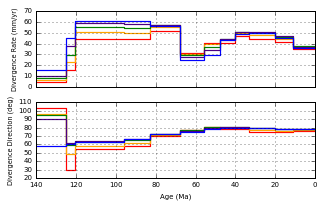

In [4]:
fig = plt.figure(figsize=(5,3))

CList = ['Red','Orange','Green','Indigo','Blue']
count = 0

#assert(len(reconstructed_flowlines) == 2)
for feature in reconstructed_flowlines:
    for reconstructed_flowline in feature:
        # Iterate over the left flowline points
        flowlinearray_left = np.empty([0,0])
        for left_point in reconstructed_flowline.get_left_flowline():
            flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
        # Iterate over the right flowline points
        flowlinearray_right = np.empty([0,0])
        for right_point in reconstructed_flowline.get_right_flowline():
            flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

        tmp = reconstructed_flowline.get_left_flowline()
        Dist = []
        Direc = []
        for segment in tmp.get_segments():
            Dist.append(segment.get_arc_length()*6371)

            SP = segment.get_start_point().to_lat_lon()
            EP = segment.get_end_point().to_lat_lon()
            deviation_of_segment_direction_from_north = Get_FZ_Directions(SP[1],SP[0],EP[1],EP[0])

            if Region not in 'PacificFarallon':
                if deviation_of_segment_direction_from_north>280:
                    deviation_of_segment_direction_from_north = deviation_of_segment_direction_from_north-360
            Direc.append(deviation_of_segment_direction_from_north)

        Rate = 2*np.asarray(Dist)/time_intervals

        StepRate = np.zeros(len(Rate)*2)
        StepRate[::2] = Rate
        StepRate[1::2] = Rate

        StepDirec = np.zeros(len(Direc)*2)
        StepDirec[::2] = Direc
        StepDirec[1::2] = Direc

        StepTime = np.zeros(len(Rate)*2)
        StepTime[::2] = times[:-1]
        StepTime[1::2] = times[1:]

        plt.subplot(211)
        if Region == 'LabradorSea':
            plt.plot(StepTime[2:],StepRate[2:],linewidth=1.2,color=CList[count])
        else:
            plt.plot(StepTime,StepRate,linewidth=1.2,color=CList[count])

        plt.subplot(212)
        if Region == 'LabradorSea':
            plt.plot(StepTime[2:],StepDirec[2:],linewidth=1.2,color=CList[count])
        else:
            plt.plot(StepTime,StepDirec,linewidth=1.2,color=CList[count])

        count=count+1
 

plt.subplot(211)
plt.gca().yaxis.grid(True,which='major')
plt.gca().xaxis.grid(True,which='major')
plt.xticks(np.arange(0,241,20),[])
plt.gca().set_xlim([np.max(times),np.min(times)])
plt.ylabel('Divergence Rate (mm/yr)',fontsize=6.5)
plt.yticks(fontsize=7)

plt.subplot(212)
plt.gca().yaxis.grid(True,which='major')
plt.gca().xaxis.grid(True,which='major')
plt.xticks(np.arange(0,241,20),fontsize=7)
plt.yticks(fontsize=7)
plt.gca().set_xlim([np.max(times),np.min(times)])
plt.xlabel('Age (Ma)',fontsize=7)
plt.ylabel('Divergence Direction (deg)',fontsize=6.5)
#plt.gca().invert_xaxis()
#plt.xlim((200,0))
fname = './Figures/SpreadingRates_%s.pdf' % Region
#fig.savefig(fname,dpi=600)

plt.show()



IOError: [Errno 2] No such file or directory: '/Users/Simon/Data/GPlates/GplatesRasters/DNSC08GRA_greyscale.jpg'

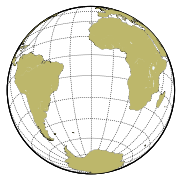

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# Plot basemap
fig = plt.figure(figsize=(3,3), dpi=600)
pmap = Basemap(projection='ortho',lon_0=SeedPoints[2][1],lat_0=SeedPoints[2][0],resolution='l')
pmap.drawcoastlines(linewidth=0.25)
pmap.fillcontinents(color='darkkhaki',lake_color='aliceblue',zorder=3)
pmap.drawmapboundary(fill_color='aliceblue')
pmap.drawmeridians(np.arange(0,360,15),linewidth=0.5)
pmap.drawparallels(np.arange(-90,90,15),linewidth=0.5)
clip_path = pmap.drawmapboundary()

ax = plt.gca()

pmap.warpimage('/Users/Simon/Data/GPlates/GplatesRasters/DNSC08GRA_greyscale.jpg',scale=0.5,alpha=0.5)

count = 0
#assert(len(reconstructed_flowlines) == 2)
for feature in reconstructed_flowlines:
    for reconstructed_flowline in feature:    # Iterate over the left flowline points
        flowlinearray_left = np.empty([0,0])
        for left_point in reconstructed_flowline.get_left_flowline():
            flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
        # Iterate over the right flowline points
        flowlinearray_right = np.empty([0,0])
        for right_point in reconstructed_flowline.get_right_flowline():
            flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

        x,y = pmap(flowlinearray_left[1::2],flowlinearray_left[::2])
        l1,=pmap.plot(x, y, clip_path=clip_path,zorder=2,linewidth=1.25,color=CList[count])
        #l3=pmap.scatter(x, y, 30, c=times,
        #                      cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=50,vmax=90)

        x,y = pmap(flowlinearray_right[1::2],flowlinearray_right[::2])
        pmap.plot(x, y, clip_path=clip_path,zorder=2,linewidth=1.25,color=CList[count])
        #l3=pmap.scatter(x, y, 30, c=times,
        #                      cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=50,vmax=90)

        #cbar = pmap.colorbar(l3,location='right',pad="5%")
        #cbar.set_label('Time (Ma)',fontsize=12)
        count=count+1

fname = './Figures/Flowlines_%s.pdf' % Region
fig.savefig(fname,dpi=600)
plt.show()

